## Importation des bibliothques

In [2]:
!pip install torchsummary

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
from timm import create_model
from torchsummary import summary
from sklearn.metrics import classification_report
import torch.nn.functional as F


## Verification du GPU

In [4]:
print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun")


GPU disponible : True
Nom du GPU : Tesla T4


## Chargement et abalyse des donnees

In [5]:
# Chemin du dossier principal
base_path = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset"

# Lister les sous-dossiers (classes)
classes = os.listdir(base_path)
print("Classes disponibles :", classes)

Classes disponibles : ['README.md', 'organized_plums_data_new.csv', 'african_plums']


In [1]:
# Chemin vers le dossier african_plums
plums_path = os.path.join(base_path, "african_plums")

# Vérification que le chemin existe
if not os.path.exists(plums_path):
    print("Erreur : Le dossier african_plums n'existe pas à l'emplacement spécifié.")
    print("Contenu du dossier african_plums_dataset :")
    print(os.listdir(base_path))
else:
    print("Dossier african_plums trouvé avec succès !")

NameError: name 'os' is not defined

In [7]:
if os.path.exists(plums_path):
    # Lister tous les sous-dossiers (classes)
    classes = [d for d in os.listdir(plums_path) 
              if os.path.isdir(os.path.join(plums_path, d))]
    
    print("\nNombre d'images par classe :")
    print("----------------------------")
    
    for class_name in classes:
        class_path = os.path.join(plums_path, class_name)
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        print(f"{class_name}: {num_images} images")


Nombre d'images par classe :
----------------------------
unripe: 826 images
cracked: 162 images
rotten: 720 images
spotted: 759 images
bruised: 319 images
unaffected: 1721 images


In [8]:
if os.path.exists(plums_path):
    # Préparer les données pour un DataFrame
    data = []
    
    for class_name in os.listdir(plums_path):
        class_path = os.path.join(plums_path, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            data.append({
                "Classe": class_name,
                "Nombre d'images": len(images),
                "Exemple de fichier": images[0] if images else "Aucune"
            })
    
    # Créer et afficher le DataFrame
    df = pd.DataFrame(data)
    print(df)
    
    # Statistiques supplémentaires
    print("\nTotal d'images:", df["Nombre d'images"].sum())

       Classe  Nombre d'images       Exemple de fichier
0      unripe              826      unripe_plum_644.png
1     cracked              162      cracked_plum_42.png
2      rotten              720      rotten_plum_584.png
3     spotted              759     spotted_plum_346.png
4     bruised              319     bruised_plum_144.png
5  unaffected             1721  unaffected_plum_970.png

Total d'images: 4507


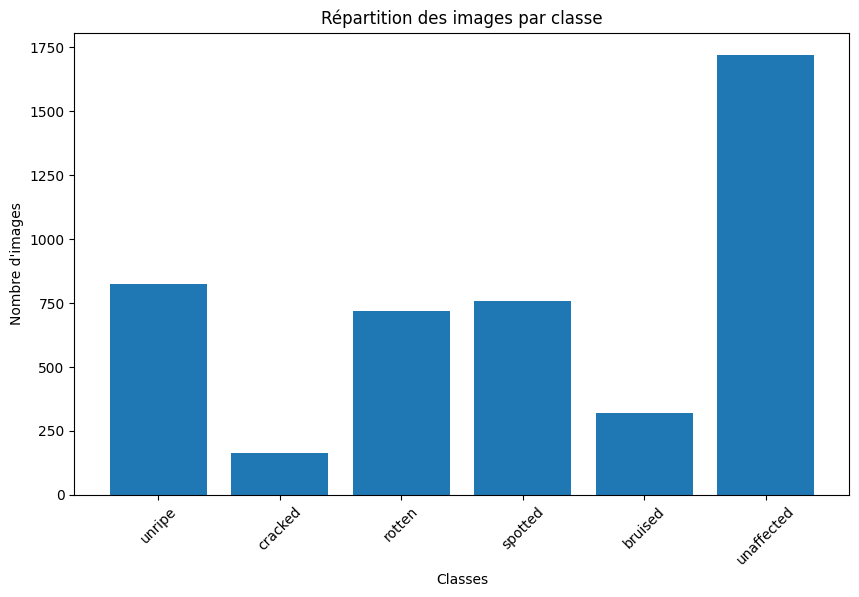

In [9]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(df["Classe"], df["Nombre d'images"])
    plt.title("Répartition des images par classe")
    plt.xlabel("Classes")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.show()

## Decoupage Train/Test (90/10)

In [10]:
# Chemins
base_path = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums"
output_path = "/kaggle/working/split_data"  # Kaggle permet d'écrire seulement dans /kaggle/working

# Créer les dossiers de sortie
os.makedirs(f"{output_path}/train", exist_ok=True)
os.makedirs(f"{output_path}/test", exist_ok=True)

# Parcourir chaque classe
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    
    # Vérifier que c'est bien un dossier
    if not os.path.isdir(class_path):
        continue
    
    # Lister toutes les images
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Séparation 90/10 avec stratification
    train_files, test_files = train_test_split(
        images,
        test_size=0.1,
        random_state=42  # Pour la reproductibilité
    )
    
    # Créer les sous-dossiers de classe
    os.makedirs(f"{output_path}/train/{class_name}", exist_ok=True)
    os.makedirs(f"{output_path}/test/{class_name}", exist_ok=True)
    
    # Copier les fichiers d'entraînement
    for file in train_files:
        src = os.path.join(class_path, file)
        dst = f"{output_path}/train/{class_name}/{file}"
        shutil.copyfile(src, dst)
    
    # Copier les fichiers de test
    for file in test_files:
        src = os.path.join(class_path, file)
        dst = f"{output_path}/test/{class_name}/{file}"
        shutil.copyfile(src, dst)

print("Division terminée !")
print(f"Train: {len(os.listdir(f'{output_path}/train/{class_name}'))} images par classe")
print(f"Test: {len(os.listdir(f'{output_path}/test/{class_name}'))} images par classe")

Division terminée !
Train: 1548 images par classe
Test: 173 images par classe


In [11]:
data = []
for class_name in os.listdir(base_path):
    train_count = len(os.listdir(f"{output_path}/train/{class_name}"))
    test_count = len(os.listdir(f"{output_path}/test/{class_name}"))
    data.append({
        'Classe': class_name,
        'Train': train_count,
        'Test': test_count,
        '% Test': f"{test_count/(train_count+test_count):.1%}"
    })

pd.DataFrame(data)

,Classe,Train,Test,% Test
0,unripe,743,83,10.0%
1,cracked,145,17,10.5%
2,rotten,648,72,10.0%
3,spotted,683,76,10.0%
4,bruised,287,32,10.0%
5,unaffected,1548,173,10.1%


## Augementation des donnees

In [15]:
data_dir = "/kaggle/working/split_data/train"

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## # 🔍 Affichage des classes


In [12]:
class_names = sorted(os.listdir(base_path)) 
print("Classes :", class_names)

Classes : ['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe']


## Oversampling des donnees peux representes

In [22]:
train_dataset = datasets.ImageFolder(
    root="/kaggle/working/split_data/train",
    transform=train_transform  # <-- utilise la data augmentation ici
)

val_dataset = datasets.ImageFolder(
    root="/kaggle/working/split_data/test",
    transform=val_transform
)

In [23]:
# Récupérer les labels du dataset
targets = train_dataset.targets
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Chargement du modele ViTf base 16

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, len(class_names))
model = model.to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

## Parametres d'entrainement

In [24]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 20

train_losses, val_losses = [], []
train_accs, val_accs = [], []


In [25]:
print(train_dataset.class_to_idx)
# Et exemple d’un batch
imgs, lbls = next(iter(train_loader))
print(lbls[:10])


{'bruised': 0, 'cracked': 1, 'rotten': 2, 'spotted': 3, 'unaffected': 4, 'unripe': 5}
tensor([0, 5, 3, 1, 1, 0, 3, 4, 0, 2])


## Resume du modele

In [19]:
model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

## Preparation des donnees de train pour le modele.

On aura plus besoin des sections suivantes. on va donc les commenter.

In [65]:
# Définir les transformations (resize, to tensor, normalisation)
#transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225])
#])

# Charger le dossier d'entraînement
#train_dataset = datasets.ImageFolder(root="/kaggle/working/split_data/train", transform=transform)
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


## Preparation des donnees de test pour le modele

In [66]:
#transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225])
#])

# Dataset de validation / test
#val_dataset = datasets.ImageFolder(root="/kaggle/working/split_data/test", transform=transform)
#val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


## Preparation des donnees de test pour l'evaluation

In [20]:
test_dataset = datasets.ImageFolder(root="/kaggle/working/split_data/test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## Boucle d'entraînement

In [26]:
best_val_loss = float('inf')
patience = 4
trigger_times = 0

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    start_time = time.time()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("⏹️ Early stopping triggered")
            break
    
    val_acc = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)

    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} - Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f} - Time: {epoch_time:.2f}s")


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Epoch [1/20] - Loss: 191.1046 - Acc: 0.2131 - Val Loss: 33.6178 - Val Acc: 0.0861 - Time: 191.56s
Epoch [2/20] - Loss: 159.5222 - Acc: 0.3411 - Val Loss: 27.3982 - Val Acc: 0.1832 - Time: 190.53s
Epoch [3/20] - Loss: 141.8227 - Acc: 0.4258 - Val Loss: 29.3013 - Val Acc: 0.1921 - Time: 191.21s
Epoch [4/20] - Loss: 123.3117 - Acc: 0.4924 - Val Loss: 21.1832 - Val Acc: 0.4592 - Time: 192.91s
Epoch [5/20] - Loss: 114.3032 - Acc: 0.5331 - Val Loss: 22.1997 - Val Acc: 0.3797 - Time: 191.73s
Epoch [6/20] - Loss: 110.8471 - Acc: 0.5498 - Val Loss: 18.9888 - Val Acc: 0.5099 - Time: 192.60s
Epoch [7/20] - Loss: 106.3034 - Acc: 0.5622 - Val Loss: 20.0549 - Val Acc: 0.4614 - Time: 191.84s
Epoch [8/20] - Loss: 98.3515 - Acc: 0.5913 - Val Loss: 16.9284 - Val Acc: 0.5563 - Time: 191.91s
Epoch [9/20] - Loss: 89.0968 - Acc: 0.6204 - Val Loss: 19.2294 

## Affichages des courbes 

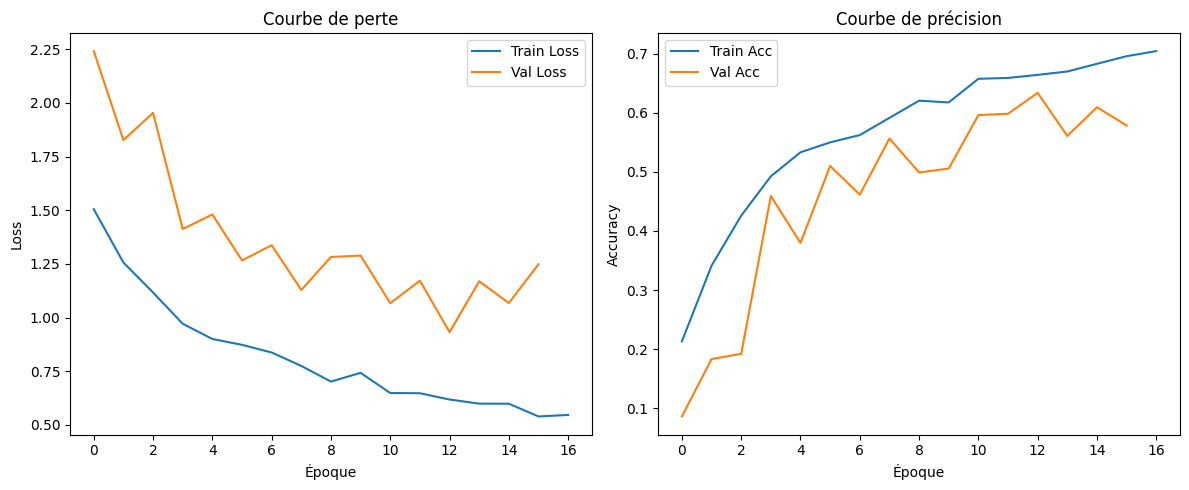

In [27]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Courbe de perte")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Courbe de précision")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation du modele

In [28]:
model.eval()

true_labels = []
predicted_labels = []
filenames = []

with torch.no_grad():  # Pas besoin du gradient ici
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        # Obtenir les noms des fichiers à partir du loader
        if hasattr(test_loader.dataset, 'samples'):
            batch_filenames = [os.path.basename(path[0]) for path in test_loader.dataset.samples]
            filenames.extend(batch_filenames)


## Rapport de classification

In [29]:
class_names = test_loader.dataset.classes

print(classification_report(true_labels, predicted_labels, target_names=class_names))


              precision    recall  f1-score   support

     bruised       0.15      0.34      0.21        32
     cracked       0.33      0.76      0.46        17
      rotten       0.83      0.67      0.74        72
     spotted       0.40      0.50      0.44        76
  unaffected       0.94      0.51      0.66       173
      unripe       0.68      0.73      0.71        83

    accuracy                           0.57       453
   macro avg       0.55      0.59      0.54       453
weighted avg       0.70      0.57      0.61       453



## Création d’un DataFrame avec infos détaillées

In [30]:
# S'assurer qu'on a bien le même nombre d'éléments
min_len = min(len(filenames), len(true_labels), len(predicted_labels))

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Fichier Image': filenames[:min_len],
    'Classe Réelle': [class_names[i] for i in true_labels[:min_len]],
    'Classe Prédite': [class_names[i] for i in predicted_labels[:min_len]]
})

# Affichage des 10 premières lignes
results_df.head(10)


,Fichier Image,Classe Réelle,Classe Prédite
0,bruised_plum_105.png,bruised,bruised
1,bruised_plum_110.png,bruised,bruised
2,bruised_plum_116.png,bruised,rotten
3,bruised_plum_117.png,bruised,spotted
4,bruised_plum_123.png,bruised,rotten
5,bruised_plum_131.png,bruised,bruised
6,bruised_plum_180.png,bruised,cracked
7,bruised_plum_181.png,bruised,spotted
8,bruised_plum_190.png,bruised,bruised
9,bruised_plum_194.png,bruised,bruised


## Sauvegarde du model

# Chemin de sauvegarde
model_path = "/kaggle/working/vit_model_poids2.pth"

# Sauvegarde complète du modèle
torch.save(model, model_path)
print("Modèle sauvegardé ici :", model_path)

torch.save(model.state_dict(), "/kaggle/working/vit_poids2.pth")


In [73]:
print('hello')

hello
